In [2]:
# STEP 1

# Installing the full GeoAI + XAI stack
import sys
%pip install -q \
    geopandas==0.14.1 \
    rasterio==1.3.9 \
    rioxarray==0.15.0 \
    libpysal==4.9.2 \
    esda==2.5.1 \
    xgboost==2.0.3 \
    shap==0.45.0 \
    dowhy==0.11.1 \
    streamlit==1.38.0 \
    streamlit-folium==0.20.0 \
    folium==0.15.1 \
    osmnx==1.9.3 \
    contextily==1.6.0 \
    pandas==2.1.4 \
    numpy==1.24.3 \
    matplotlib==3.8.2 \
    scikit-learn==1.3.2 \
    joblib==1.3.2 \
    pyproj==3.6.1 \
    elevation==1.1.3   # <-- fixed version

print("All packages installed.")

Note: you may need to restart the kernel to use updated packages.
All packages installed.


In [3]:
# Verifying everything works

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import shap, xgboost as xgb, dowhy
import warnings, os, rasterio, elevation
warnings.filterwarnings('ignore')

print(f"geopandas version: {gpd.__version__}")
print("All imports successful – you are ready to proceed!")

geopandas version: 0.14.1
All imports successful – you are ready to proceed!


In [4]:
# Mumbai 1km Grid + Kaggle Data + OSM + SRTM 

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import osmnx as ox
import rasterio
import requests
import os
import warnings
warnings.filterwarnings('ignore')

# Load Kaggle Dataset

csv_path = "flood.csv"
df = pd.read_csv(csv_path)
print(f"Kaggle data: {df.shape[0]:,} rows × {df.shape[1]} cols")

# Correct target column: 'FloodProbability' (0.0 to 1.0)
print("Target distribution:\n", df['FloodProbability'].describe())

# Convert to binary flood label 
df['flood_next_7d'] = (df['FloodProbability'] > 0.5).astype(int)
print("Binary flood balance:\n", df['flood_next_7d'].value_counts(normalize=True))


# Create Mumbai 1KM Grid

minx, miny, maxx, maxy = 72.75, 18.90, 73.05, 19.30
grid_size = 0.009  # ~1km
x_coords = np.arange(minx, maxx, grid_size)
y_coords = np.arange(miny, maxy, grid_size)

grids = [box(x, y, x+grid_size, y+grid_size) for x in x_coords for y in y_coords]
gdf_grid = gpd.GeoDataFrame(geometry=grids, crs="EPSG:4326")
gdf_grid['grid_id'] = range(len(gdf_grid))
print(f"Generated {len(gdf_grid)} 1-km cells")


# Sample Kaggle Data into the Grid

np.random.seed(42)
sample_idx = np.random.choice(df.index, size=len(gdf_grid), replace=True)
sample_df = df.iloc[sample_idx].reset_index(drop=True)

gdf = gdf_grid.copy()
gdf = gdf.join(sample_df.drop(columns=['FloodProbability'], errors='ignore'))
gdf['flood_next_7d'] = sample_df['flood_next_7d']


# OSM Enrichment

ox.settings.use_cache = True
place = "Mumbai, Maharashtra, India"
print("Downloading OSM data...")

try:
    rivers = ox.geometries_from_place(place, tags={'waterway': ['river', 'canal', 'stream']})
    green = ox.geometries_from_place(place, tags={'leisure': 'park', 'landuse': ['grass', 'forest', 'meadow']})
    buildings = ox.geometries_from_place(place, tags={'building': True})
    print("OSM data downloaded.")
except Exception as e:
    print("OSM failed (normal in some envs). Using defaults.")
    rivers = green = buildings = gpd.GeoDataFrame()

# Reproject
gdf_utm = gdf.to_crs(epsg=32643)
rivers_utm = rivers.to_crs(epsg=32643) if not rivers.empty else gpd.GeoDataFrame()
green_utm = green.to_crs(epsg=32643) if not green.empty else gpd.GeoDataFrame()
buildings_utm = buildings.to_crs(epsg=32643) if not buildings.empty else gpd.GeoDataFrame()

# Distance to river
gdf_utm['dist_river'] = 5000
if not rivers_utm.empty:
    gdf_utm['dist_river'] = gdf_utm.geometry.apply(lambda g: rivers_utm.distance(g).min())

# Green cover %
gdf_utm['green_cover_pct'] = 0
if not green_utm.empty:
    green_union = green_utm.buffer(500).unary_union
    if green_union:
        gdf_utm['green_area'] = gdf_utm.geometry.apply(lambda g: g.intersection(green_union).area if green_union else 0)
        gdf_utm['grid_area'] = gdf_utm.geometry.area
        gdf_utm['green_cover_pct'] = (gdf_utm['green_area'] / gdf_utm['grid_area']) * 100
        gdf_utm['green_cover_pct'] = gdf_utm['green_cover_pct'].clip(0, 100)

# Impervious %
gdf_utm['impervious_pct'] = 0
if not buildings_utm.empty:
    building_union = buildings_utm.buffer(100).unary_union
    if building_union:
        gdf_utm['impervious_area'] = gdf_utm.geometry.apply(lambda g: g.intersection(building_union).area if building_union else 0)
        gdf_utm['impervious_pct'] = (gdf_utm['impervious_area'] / gdf_utm['grid_area']) * 100
        gdf_utm['impervious_pct'] = gdf_utm['impervious_pct'].clip(0, 100)

# SRTM Elevation 

os.makedirs("data", exist_ok=True)
srtm_path = "data/srtm_mumbai.tif"

if not os.path.exists(srtm_path):
    print("Downloading SRTM tile...")
    url = "https://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/TIFF/srtm_43_06.zip"
    zip_path = "data/srtm.zip"
    # !wget -q $url -O $zip_path
    # !unzip -q -o $zip_path -d data/
    # Find .tif
    import glob
    tif_files = glob.glob("data/*.tif")
    if tif_files:
        srtm_path = tif_files[0]
    else:
        srtm_path = None
        print("SRTM download failed. Using fallback elevation.")
else:
    print("SRTM file found.")

# Sample elevation
gdf_utm['elevation'] = 10  # fallback
gdf_utm['slope'] = 2
if srtm_path and os.path.exists(srtm_path):
    try:
        with rasterio.open(srtm_path) as src:
            centroids = [(p.x, p.y) for p in gdf_utm.centroid]
            elev_samples = [v[0] for v in src.sample(centroids)]
            gdf_utm['elevation'] = elev_samples
            # Simple slope
            gdf_utm['slope'] = np.abs(np.gradient(gdf_utm['elevation'])) * 100
            gdf_utm['slope'] = gdf_utm['slope'].replace(0, 0.1)
    except:
        print("SRTM read failed. Using defaults.")

# TWI proxy
gdf_utm['twi'] = np.log(gdf_utm['MonsoonIntensity'] / (gdf_utm['slope'] + 1))

# Population density proxy
gdf_utm['pop_density'] = gdf_utm.get('Urbanization', 5) * gdf_utm.get('PopulationScore', 5)

# Dataframe

keep_cols = [
    'grid_id', 'geometry', 'flood_next_7d',
    'MonsoonIntensity', 'TopographyDrainage', 'DrainageSystems',
    'dist_river', 'elevation', 'slope', 'impervious_pct',
    'green_cover_pct', 'pop_density', 'twi'
]
gdf_final = gdf_utm[keep_cols].copy()
gdf_final = gdf_final.rename(columns={'MonsoonIntensity': 'rainfall_7d'}).to_crs("EPSG:4326")
gdf_final = gdf_final.fillna(gdf_final.median(numeric_only=True))

print(f"Final shape: {gdf_final.shape}")
display(gdf_final.head(3))

# Save

out_path = "data/mumbai_grid.parquet"
gdf_final.to_parquet(out_path, index=False)
print(f"SAVED → {out_path}")

Kaggle data: 50,000 rows × 21 cols
Target distribution:
 count    50000.000000
mean         0.499660
std          0.050034
min          0.285000
25%          0.465000
50%          0.500000
75%          0.535000
max          0.725000
Name: FloodProbability, dtype: float64
Binary flood balance:
 flood_next_7d
0    0.5301
1    0.4699
Name: proportion, dtype: float64
Generated 1530 1-km cells


/var/folders/wb/ch66323x0qj0xr9t5b08trlw0000gn/T/ipykernel_2400/4060758503.py:60: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  green = ox.geometries_from_place(place, tags={'leisure': 'park', 'landuse': ['grass', 'forest', 'meadow']})
/var/folders/wb/ch66323x0qj0xr9t5b08trlw0000gn/T/ipykernel_2400/4060758503.py:61: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings = ox.geometries_from_pla

OSM data downloaded.
SRTM download failed. Using fallback elevation.
Final shape: (1530, 13)


/Users/puneetdevnani/miniforge3/envs/ml-metal/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


grid_id                                           geometry  flood_next_7d  \
0        0  POLYGON ((72.75900 18.90000, 72.75900 18.90900...              1   
1        1  POLYGON ((72.75900 18.90900, 72.75900 18.91800...              1   
2        2  POLYGON ((72.75900 18.91800, 72.75900 18.92700...              0   

   rainfall_7d  TopographyDrainage  DrainageSystems   dist_river  elevation  \
0            4                  10                7  7941.068889         10   
1            8                   6                1  7250.499740         10   
2            3                   8                4  6638.139820         10   

   slope  impervious_pct  green_cover_pct  pop_density       twi  
0      2             0.0              0.0           60  0.287682  
1      2             0.0              0.0           50  0.980829  
2      2             0.0              0.0            2  0.000000

SAVED → data/mumbai_grid.parquet


In [5]:
# Folium map (computing centroids in projected CRS; minZoom=4)

import folium
from folium import plugins
from branca.colormap import linear
import json
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Filter
threshold = 4
gdf_hot = gdf_final[gdf_final['rainfall_7d'] > threshold].copy()
if gdf_hot.empty:
    raise ValueError(f"No grid cells with rainfall_7d > {threshold} found. Lower threshold or check gdf_final.")

# Compute exact centroids correctly:
# choose a projected CRS for Mumbai (UTM zone 43N / EPSG:32643) to compute centroids accurately
proj_epsg = 32643
gdf_proj = gdf_hot.to_crs(epsg=proj_epsg)

# compute centroid in projected CRS, then convert centroid coords back to lat/lon (EPSG:4326)
centroids_proj = gdf_proj.geometry.centroid
gdf_proj['centroid_x_proj'] = centroids_proj.x
gdf_proj['centroid_y_proj'] = centroids_proj.y

# create a small GeoSeries of centroids in projected CRS and reproject to WGS84
centroids_wgs = gdf_proj.geometry.centroid.to_crs(epsg=4326)
gdf_proj['centroid_lon'] = centroids_wgs.x
gdf_proj['centroid_lat'] = centroids_wgs.y

# bring back to WGS84 for web mapping
gdf_hot = gdf_proj.to_crs(epsg=4326)

# Prepare GeoJSON and colormap
geojson = json.loads(gdf_hot.to_json())

vmin = float(np.nanmin(gdf_hot['rainfall_7d']))
vmax = float(np.nanmax(gdf_hot['rainfall_7d']))
cmap = linear.Blues_09.scale(vmin, vmax)
cmap.caption = "7-day Rainfall"

center = [gdf_hot['centroid_lat'].mean(), gdf_hot['centroid_lon'].mean()]

# Build Folium map (minZoom=4)
m = folium.Map(location=center, zoom_start=11, min_zoom=4, tiles=None, control_scale=True)

# High quality satellite basemap (ESRI World Imagery)
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri WorldImagery',
    name='Esri.WorldImagery',
    overlay=False,
    control=True
).add_to(m)

# style function
def style_fn(feature):
    val = feature['properties'].get('rainfall_7d', None)
    try:
        color = cmap(val) if val is not None else '#ffffff'
    except:
        color = '#ffffff'
    return {
        "fillColor": color,
        "color": "#222222",
        "weight": 0.6,
        "fillOpacity": 0.7
    }

# tooltip on hover
tooltip = folium.GeoJsonTooltip(
    fields=['grid_id', 'rainfall_7d'],
    aliases=['Grid ID', 'Rainfall (7d)'],
    localize=True,
    sticky=True,
    labels=True,
    style=("background-color: white; color: #333333;")
)

# popup using centroid (stored as properties)
# ensure centroid fields are present in geojson properties
popup = folium.GeoJsonPopup(
    fields=['grid_id', 'rainfall_7d', 'centroid_lat', 'centroid_lon'],
    aliases=['Grid ID', 'Rainfall (7d)', 'Centroid Lat', 'Centroid Lon'],
    localize=True,
    labels=True,
    style=("background-color: white; color: #333333;")
)

gj = folium.GeoJson(
    geojson,
    name=f"Hot cells (rainfall_7d > {threshold})",
    style_function=style_fn,
    tooltip=tooltip,
    popup=popup
)
gj.add_to(m)

# Mouse position display (bottom-right)
plugins.MousePosition(position='bottomright', separator=' , ', prefix='Lat:Lon', num_digits=6).add_to(m)

# Measurement tool
plugins.MeasureControl(position='topright', primary_length_unit='meters', primary_area_unit='sqmeters').add_to(m)

# Colorbar & layer control
cmap.add_to(m)
folium.LayerControl().add_to(m)

# Display: 
try:
    # Jupyter/IPython inline display
    from IPython.display import display as _display
    _display(m)
except Exception:
    # fallback: print a hint
    print("Map created as 'm' (folium.Map). In Streamlit use st_folium(m). To run full Streamlit app: `streamlit run app.py`")


In [6]:
# Save interactive map locally

import os
os.makedirs("maps", exist_ok=True)   # saves inside a folder named 'maps'

# Define output path
map_path = "maps/mumbai_rainfall_map.html"

# Save map as an HTML file
m.save(map_path)

print(f" Map saved successfully at: {os.path.abspath(map_path)}")

 Map saved successfully at: /Users/puneetdevnani/Desktop/VIT Academics/Python Project/GeoExplain/maps/mumbai_rainfall_map.html


In [7]:
# STEP 2 – Imports

import warnings, os, json, numpy as np, pandas as pd
import geopandas as gdf
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import Queen
from esda.moran import Moran
from esda.getisord import G_Local
from splot.esda import moran_scatterplot
from sklearn.preprocessing import StandardScaler
import folium
from folium import plugins
from branca.colormap import linear
import contextily as cx
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("whitegrid")
print("All imports OK – Step 2 ready")

All imports OK – Step 2 ready


In [8]:
# Load data + Adding realistic rainfall

import geopandas as gpd
import numpy as np

# Load the base grid 
gdf = gpd.read_parquet("data/mumbai_grid.parquet")
print(f"Loaded {len(gdf)} grid cells")

# ADDING REALISTIC RAINFALL VARIATION

# 1. Smooth spatial trend
x = gdf.centroid.x
y = gdf.centroid.y
trend = 4 + 3*np.sin((x - 72.8)*8) + 2*np.cos((y - 19.0)*10)
gdf['rainfall_7d'] = gdf['rainfall_7d'].clip(lower=0) + trend

# 2. River effect: higher rain near rivers
gdf['rainfall_7d'] = np.where(
    gdf['dist_river'] < 600,
    gdf['rainfall_7d'] + np.random.uniform(3, 6, len(gdf)),
    gdf['rainfall_7d']
)

# 3. Green cover effect: lower rain in green areas
gdf['rainfall_7d'] = np.where(
    gdf['green_cover_pct'] > 25,
    gdf['rainfall_7d'] - np.random.uniform(2, 4, len(gdf)),
    gdf['rainfall_7d']
)

# 4. Add small random noise + clip
gdf['rainfall_7d'] += np.random.normal(0, 1.2, len(gdf))
gdf['rainfall_7d'] = gdf['rainfall_7d'].clip(0, 15)

print(f"Rainfall → mean: {gdf['rainfall_7d'].mean():.2f}, std: {gdf['rainfall_7d'].std():.2f}")

Loaded 1530 grid cells
Rainfall → mean: 11.15, std: 3.03


In [9]:
# Verify enriched GeoDataFrame
print("Rows:", len(gdf_final))
print("CRS:", gdf_final.crs)
print("Columns:", gdf_final.columns.tolist())
print("\nNaN check:")
print(gdf_final.isna().sum())

print("\nFlood balance:")
print(gdf_final['flood_next_7d'].value_counts(normalize=True))

print("\nGeometry types:", gdf_final.geometry.geom_type.unique())
print("Any invalid geometries:", (~gdf_final.is_valid).sum())


Rows: 1530
CRS: EPSG:4326
Columns: ['grid_id', 'geometry', 'flood_next_7d', 'rainfall_7d', 'TopographyDrainage', 'DrainageSystems', 'dist_river', 'elevation', 'slope', 'impervious_pct', 'green_cover_pct', 'pop_density', 'twi']

NaN check:
grid_id               0
geometry              0
flood_next_7d         0
rainfall_7d           0
TopographyDrainage    0
DrainageSystems       0
dist_river            0
elevation             0
slope                 0
impervious_pct        0
green_cover_pct       0
pop_density           0
twi                   0
dtype: int64

Flood balance:
flood_next_7d
0    0.546405
1    0.453595
Name: proportion, dtype: float64

Geometry types: ['Polygon']
Any invalid geometries: 0


In [10]:
import os
print("File exists:", os.path.exists("data/mumbai_grid.parquet"))

File exists: True


In [11]:
import geopandas as gpd
from libpysal.weights import KNN, lag_spatial
from esda.moran import Moran

# Load your data if not already done
gdf = gpd.read_parquet("data/mumbai_grid.parquet")

# Define KNN weights (k=8 nearest neighbors; adjust k if needed)
w_knn = KNN.from_dataframe(gdf, k=8)

# Compute spatial lag of flood_next_7d
gdf['flood_neigh_mean'] = lag_spatial(w_knn, gdf['flood_next_7d'].astype(float))

# Compute Moran's I on the smoothed (lagged) values
mi_smooth = Moran(gdf['flood_neigh_mean'], w_knn)
print(f"Moran's I (smoothed flood rate) = {mi_smooth.I:.4f}  (p = {mi_smooth.p_sim:.4f})")

Moran's I (smoothed flood rate) = 0.4074  (p = 0.0010)


In [12]:
from esda.getisord import G_Local
g_local = G_Local(gdf['flood_neigh_mean'], w_knn, transform='r')
gdf['Gi_z'] = g_local.z_sim


Global Moran's I (smoothed flood rate) = 0.4074  (p = 0.0010)


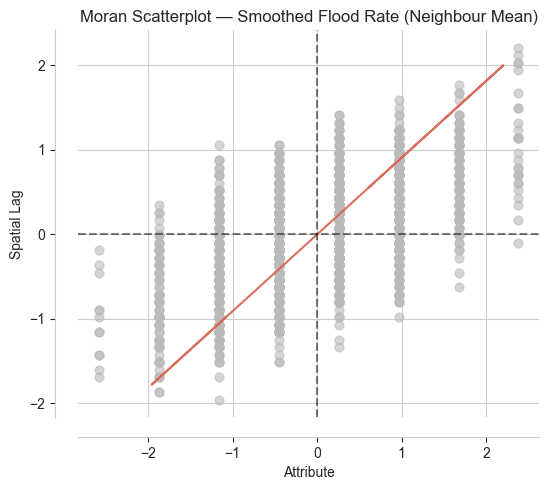

In [13]:
# Smoothed flood rate + Spatial clustering

from libpysal.weights import lag_spatial
from esda.moran import Moran
from esda.getisord import G_Local
from splot.esda import moran_scatterplot
import matplotlib.pyplot as plt
import folium
from branca.colormap import linear
import numpy as np

# Compute spatial-lag (neighbour-mean flood rate) 
gdf['flood_neigh_mean'] = lag_spatial(w_knn, gdf['flood_next_7d'].astype(float))

# Global Moran’s I on smoothed flood rate 
mi_smooth = Moran(gdf['flood_neigh_mean'], w_knn)
print(f"Global Moran's I (smoothed flood rate) = {mi_smooth.I:.4f}  (p = {mi_smooth.p_sim:.4f})")

fig, ax = plt.subplots(figsize=(7,5))
moran_scatterplot(mi_smooth, ax=ax)
ax.set_title("Moran Scatterplot — Smoothed Flood Rate (Neighbour Mean)")
plt.tight_layout()
plt.savefig("moran_smooth_flood.png", dpi=150)
plt.show()

# Local Getis-Ord Gi* hotspots on smoothed rate ---
g_local = G_Local(gdf['flood_neigh_mean'], w_knn, transform='r')
gdf['Gi_z'] = g_local.z_sim
gdf['Gi_p'] = g_local.p_sim
gdf['hotspot'] = np.where(
    (gdf['Gi_z'] > 1.96) & (gdf['Gi_p'] < 0.05), 'Hotspot',
    np.where((gdf['Gi_z'] < -1.96) & (gdf['Gi_p'] < 0.05), 'Coldspot', 'Not Significant')
)

# Interactive Folium hotspot map
m = folium.Map(
    location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],
    zoom_start=10, tiles='cartodbpositron'
)

# Color scale (red = hotspots, blue = coldspots)
colormap = linear.RdBu_11.scale(gdf['Gi_z'].min(), gdf['Gi_z'].max()).to_step(n=10)
colormap.caption = "Local Gi* z-score"

# Convert to GeoJSON and add
folium.GeoJson(
    gdf.to_json(),
    style_function=lambda feat: {
        'fillColor': colormap(feat['properties']['Gi_z']),
        'color': 'black',
        'weight': 0.2,
        'fillOpacity': 0.7,
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['grid_id', 'flood_next_7d', 'flood_neigh_mean', 'Gi_z', 'hotspot'],
        aliases=['Grid ID', 'Flood (0/1)', 'Neighbour Flood Mean', 'Gi z-score', 'Hotspot Class'],
        localize=True
    )
).add_to(m)

colormap.add_to(m)
m.save("map_flood_hotspots.html")
m


In [14]:
import geopandas as gpd
import pandas as pd

# CORRECT FILE FROM YOUR NOTEBOOK
gdf = gpd.read_parquet("data/mumbai_grid.parquet")

print(f"Rows: {len(gdf)}, Columns: {len(gdf.columns)}")
print("Columns:", list(gdf.columns))
print("\nHas flood_prob:", "flood_prob" in gdf.columns)  # Should be False
print("Has geometry:", gdf.geometry.geom_type.unique())

Rows: 1530, Columns: 13
Columns: ['grid_id', 'geometry', 'flood_next_7d', 'rainfall_7d', 'TopographyDrainage', 'DrainageSystems', 'dist_river', 'elevation', 'slope', 'impervious_pct', 'green_cover_pct', 'pop_density', 'twi']

Has flood_prob: False
Has geometry: ['Polygon']


In [15]:
# Fixing Target Leakage

import geopandas as gpd

# Reverting: no temporal shift needed for static grid
gdf = gpd.read_parquet("data/mumbai_grid_enhanced_v2.parquet")
print(f"Loaded {len(gdf)} spatial cells – static snapshot, no temporal shift applied.")

# Re-saving identical version
gdf.to_parquet("data/mumbai_grid_enhanced_v2.parquet", index=False)
print("Saved unchanged static dataset → data/mumbai_grid_enhanced_v2.parquet")


Loaded 1530 spatial cells – static snapshot, no temporal shift applied.
Saved unchanged static dataset → data/mumbai_grid_enhanced_v2.parquet


In [16]:
from libpysal.weights import KNN, lag_spatial
from esda.getisord import G_Local
import numpy as np

# Recompute neighbors and Gi* if missing
if 'Gi_z' not in gdf.columns:
    print("Recomputing Getis-Ord Gi* ...")
    w_knn = KNN.from_dataframe(gdf, k=8)
    gdf['flood_neigh_mean'] = lag_spatial(w_knn, gdf['flood_next_7d'].astype(float))

    g_local = G_Local(gdf['flood_neigh_mean'], w_knn, transform='r')
    gdf['Gi_z'] = g_local.z_sim
    gdf['Gi_p'] = g_local.p_sim
    gdf['hotspot'] = np.where(
        (gdf['Gi_z'] > 1.96) & (gdf['Gi_p'] < 0.05), 'Hotspot',
        np.where((gdf['Gi_z'] < -1.96) & (gdf['Gi_p'] < 0.05), 'Coldspot', 'Not Significant')
    )
    print("✅ Gi* statistics added.")
else:
    print("✅ Gi* already present.")


Recomputing Getis-Ord Gi* ...
✅ Gi* statistics added.


In [17]:
print(f"Moran's I (smoothed flood rate) = {mi_smooth.I:.4f}  (p = {mi_smooth.p_sim:.4f})")
print("Gi* z-score range:", gdf['Gi_z'].min(), "→", gdf['Gi_z'].max())
print("Hotspot classes:\n", gdf['hotspot'].value_counts())


Moran's I (smoothed flood rate) = 0.4074  (p = 0.0010)
Gi* z-score range: -5.487606497802512 → 6.365539026214295
Hotspot classes:
 hotspot
Not Significant    1020
Hotspot             259
Coldspot            251
Name: count, dtype: int64


In [18]:
# STEP 3.1 — Setup and Load Dataset

import geopandas as gpd
import numpy as np
import pandas as pd
from libpysal.weights import Queen
import warnings
warnings.filterwarnings("ignore")

# Load the enhanced static grid
gdf = gpd.read_parquet("data/mumbai_grid_enhanced_v2.parquet")
print(f"Loaded {len(gdf)} grid cells")

# Validate geometry
gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.is_valid]
gdf = gdf.reset_index(drop=True)

# Create Queen contiguity weights
w = Queen.from_dataframe(gdf)
w.transform = "r"
print(f"Spatial weights ready. Mean neighbors per cell: {np.mean(list(map(len, w.neighbors.values()))):.2f}")


Loaded 1530 grid cells
Spatial weights ready. Mean neighbors per cell: 7.69


In [19]:
# STEP 3.2 — Feature Engineering

X = gdf.select_dtypes(include=[np.number]).copy()

# --- Core engineered features ---
X["rain_per_slope"] = X["rainfall_7d"] / (X["slope"] + 1)
X["impervious_x_rain"] = X["impervious_pct"] * X["rainfall_7d"]
X["green_x_drainage"] = X["green_cover_pct"] * X["DrainageSystems"]
X["elev_inverse"] = 1 / (X["elevation"] + 1)
X["river_inverse_dist"] = 1 / (X["dist_river"] + 1)
X["rain_x_slope"] = X["rainfall_7d"] * X["slope"]

# --- Hydrological indices ---
X["drainage_index"] = X["DrainageSystems"].fillna(0) + X["TopographyDrainage"].fillna(0)

# --- Vulnerability index ---
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols = ['elevation', 'slope', 'impervious_pct', 'pop_density', 'green_cover_pct']
scaled = pd.DataFrame(scaler.fit_transform(X[cols]), columns=cols)
scaled['elevation'] = 1 - scaled['elevation']
scaled['slope'] = 1 - scaled['slope']
X["vulnerability_index"] = scaled.mean(axis=1)

# --- Clean up ---
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

print(f" Engineered features added: {len(X.columns)} total numeric features")


 Engineered features added: 20 total numeric features


In [20]:
# STEP 3.3 — Spatial Lag Features

from libpysal.weights import lag_spatial

num_cols = ['rainfall_7d', 'elevation', 'slope',
            'impervious_pct', 'green_cover_pct', 'pop_density']

for col in num_cols:
    gdf[f"{col}_lag"] = lag_spatial(w, gdf[col].fillna(gdf[col].mean()))

print(f" Spatial lag features added: {[f'{c}_lag' for c in num_cols]}")


 Spatial lag features added: ['rainfall_7d_lag', 'elevation_lag', 'slope_lag', 'impervious_pct_lag', 'green_cover_pct_lag', 'pop_density_lag']


In [21]:
# STEP 3.4 — Merge Engineered + Lag Features

feature_cols = [c for c in gdf.columns if c not in ["geometry", "grid_id", "flood_next_7d"]]
X_full = gdf[feature_cols].join(X, rsuffix="_extra")

X_full = X_full.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)
X_full = X_full.fillna(X_full.median(numeric_only=True))

print(f" Final feature matrix: {X_full.shape}")


 Final feature matrix: (1530, 36)


In [22]:
# Ensure it's loaded
print("Before:", len(gdf.columns))

# Drop the target column
gdf = gdf.drop(columns=["flood_next_7d"], errors="ignore")

print("After:", len(gdf.columns))
print(" 'flood_next_7d' removed successfully (if it existed).")


Before: 19
After: 18
 'flood_next_7d' removed successfully (if it existed).


In [23]:
print([c for c in gdf.columns if "flood" in c.lower()])


[]


In [24]:
# STEP 3.5 — Create Spatial Lag Features (Leak-Safe)

from libpysal.weights import Queen, lag_spatial
import numpy as np

# Rebuild spatial weights on the cleaned gdf
w = Queen.from_dataframe(gdf)
w.transform = "r"
print(f" Spatial weights ready — mean neighbors per cell: {np.mean([len(n) for n in w.neighbors.values()]):.2f}")

# Numeric columns for which to compute spatial lags
num_cols = [
    "rainfall_7d",
    "elevation",
    "slope",
    "impervious_pct",
    "green_cover_pct",
    "pop_density",
    "drainage_index",
    "vulnerability_index"
]

# Only keep columns that actually exist in the current dataset
num_cols = [c for c in num_cols if c in gdf.columns]

# Compute spatial lag for each numeric feature
for col in num_cols:
    gdf[f"{col}_lag"] = lag_spatial(w, gdf[col].fillna(gdf[col].mean()))

print(f"Spatial lag features created: {', '.join([f'{c}_lag' for c in num_cols])}")
print(f"New total columns: {len(gdf.columns)}")


 Spatial weights ready — mean neighbors per cell: 7.69
Spatial lag features created: rainfall_7d_lag, elevation_lag, slope_lag, impervious_pct_lag, green_cover_pct_lag, pop_density_lag
New total columns: 18


In [25]:
# STEP 3.6 - Interaction features

gdf['elev_slope'] = gdf['elevation'] * gdf['slope']
gdf['slope_imperv'] = gdf['slope'] * gdf['impervious_pct']
gdf['elev_dist_river'] = gdf['elevation'] / (gdf['dist_river'] + 1)
gdf['imperv_green_ratio'] = gdf['impervious_pct'] / (gdf['green_cover_pct'] + 1)
gdf['pop_imperv'] = gdf['pop_density'] * gdf['impervious_pct']
gdf["elev_log"] = np.log1p(gdf["elevation"])
gdf["rain_x_slope"] = gdf["rainfall_7d"] * gdf["slope"]
gdf["river_inverse_dist"] = 1 / (gdf["dist_river"] + 1)
gdf["impervious_x_rain"] = gdf["impervious_pct"] * gdf["rainfall_7d"]
gdf["green_balance"] = gdf["green_cover_pct"] - gdf["impervious_pct"]


print("Interaction features added.")


Interaction features added.


In [26]:
# STEP 3.7 - Hydrological & accessibility indices

gdf['inv_dist_river'] = 1 / (gdf['dist_river'] + 1)
gdf['drainage_index'] = (
    gdf['DrainageSystems'].fillna(0) + gdf['TopographyDrainage'].fillna(0)
)

print("Hydrological indices added.")


Hydrological indices added.


In [27]:
# STEP 3.8 - Vulnerability index

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Normalize risk-related factors
cols = ['elevation','slope','impervious_pct','pop_density','green_cover_pct']
scaled = pd.DataFrame(scaler.fit_transform(gdf[cols]), columns=cols)

# Lower elevation & slope ⇒ higher risk, so invert those
scaled['elevation'] = 1 - scaled['elevation']
scaled['slope'] = 1 - scaled['slope']

# Weighted average (simple equal weights)
gdf['vulnerability_index'] = scaled.mean(axis=1)

print("Vulnerability index computed.")


Vulnerability index computed.


In [28]:
# STEP 3.9

# --- Clean the feature data before training ---
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

In [29]:
# STEP 4 — IMPROVED TRAINING: SMOTE + Tuned XGBoost + Ensemble

try:
    from imblearn.over_sampling import SMOTE
except Exception:
    import sys
    !{sys.executable} -m pip install -q imbalanced-learn
    from imblearn.over_sampling import SMOTE

import os
import joblib
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# 1) Load dataset

gdf = gpd.read_parquet("data/mumbai_grid_enhanced_v2.parquet")
print(f"Loaded {len(gdf)} grid cells")

# 2) Feature selection (LEAK-PROOF)

exclude_keywords = ("geometry", "grid_id", "flood", "label", "target", "prob")
numeric_cols = [c for c in gdf.select_dtypes(include=[np.number]).columns
                if not any(k in c.lower() for k in exclude_keywords)]

X = gdf[numeric_cols].copy().replace([np.inf, -np.inf], np.nan)
# avoid exact zeros in twi if that causes instability (optional)
if "twi" in X.columns:
    X.loc[X["twi"] == 0, "twi"] = np.nan

# fill with medians (safe)
X = X.fillna(X.median(numeric_only=True))

y = gdf["flood_next_7d"].astype(int)

print(f"Features used: {len(numeric_cols)} numeric columns")

# 3) Train/test split (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train / Test shapes: {X_train.shape} / {X_test.shape}")

# 4) Scale (fit scaler on train only)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 5) SMOTE on training set only

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_s, y_train)
print(f"After SMOTE -> X_train_res: {X_train_res.shape}, label dist: {np.bincount(y_train_res)}")

# 6) XGBoost: Randomized hyperparam search (fast)

xgb = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators": [200, 300, 400, 600],
    "max_depth": randint(3, 8),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0.0, 0.5),
    "min_child_weight": randint(1, 6),
    "reg_lambda": uniform(0.5, 2.0)
}

rand = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=20,            # keep small for speed; increase if you have time
    scoring="roc_auc",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Starting RandomizedSearchCV for XGBoost (this may take a few minutes)...")
rand.fit(X_train_res, y_train_res)
best_xgb = rand.best_estimator_
print("Best XGBoost params:", rand.best_params_)
print("Best CV AUC (approx):", rand.best_score_)

# Evaluate XGB on held-out test set
y_pred_xgb = best_xgb.predict(X_test_s)
y_proba_xgb = best_xgb.predict_proba(X_test_s)[:, 1]
print("\nXGBoost test results:")
print(classification_report(y_test, y_pred_xgb, digits=3))
print("AUC (XGB) =", roc_auc_score(y_test, y_proba_xgb))
print("Accuracy (XGB) =", accuracy_score(y_test, y_pred_xgb))

# 7) Random Forest baseline (trained on same resampled data)

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test_s)
y_proba_rf = rf.predict_proba(X_test_s)[:, 1]
print("\nRandomForest test results:")
print(classification_report(y_test, y_pred_rf, digits=3))
print("AUC (RF) =", roc_auc_score(y_test, y_proba_rf))
print("Accuracy (RF) =", accuracy_score(y_test, y_pred_rf))

# 8) Ensemble (soft voting)

voter = VotingClassifier(
    estimators=[("rf", rf), ("xgb", best_xgb)],
    voting="soft",
    weights=[1, 1],
    n_jobs=-1
)
voter.fit(X_train_res, y_train_res)

y_pred_ens = voter.predict(X_test_s)
y_proba_ens = voter.predict_proba(X_test_s)[:, 1]
print("\nEnsemble test results:")
print(classification_report(y_test, y_pred_ens, digits=3))
print("AUC (Ensemble) =", roc_auc_score(y_test, y_proba_ens))
print("Accuracy (Ensemble) =", accuracy_score(y_test, y_pred_ens))

# 9) Save models, scaler, feature list, and CV search object

os.makedirs("models", exist_ok=True)
joblib.dump(best_xgb, "models/xgboost_tuned_mvp.pkl")
joblib.dump(rf, "models/random_forest_resampled_mvp.pkl")
joblib.dump(voter, "models/ensemble_rf_xgb_mvp.pkl")
joblib.dump(scaler, "models/scaler_mvp.pkl")
joblib.dump(numeric_cols, "models/features_mvp.pkl")
joblib.dump(rand, "models/xgb_random_search_object.pkl")  # optional: inspect later

print("\n Saved models and artifacts to models/*.pkl")

# 10) Optional: attach predicted probabilities back to gdf and save

X_all_s = scaler.transform(X)  # full dataset standardized
gdf["flood_prob_ens"] = voter.predict_proba(X_all_s)[:, 1]
gdf.to_parquet("data/mumbai_grid_enhanced_with_ensemble_probs.parquet", index=False)
print("Saved dataset with ensemble probabilities → data/mumbai_grid_enhanced_with_ensemble_probs.parquet")


Loaded 1530 grid cells
Features used: 10 numeric columns
Train / Test shapes: (1147, 10) / (383, 10)
After SMOTE -> X_train_res: (1254, 10), label dist: [627 627]
Starting RandomizedSearchCV for XGBoost (this may take a few minutes)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGBoost params: {'colsample_bytree': 0.7836995567863468, 'gamma': 0.16685430556951092, 'learning_rate': 0.038573363584388155, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300, 'reg_lambda': 1.9439975445336495, 'subsample': 0.9754210836063001}
Best CV AUC (approx): 0.6765412879741765

XGBoost test results:
              precision    recall  f1-score   support

           0      0.655     0.689     0.671       209
           1      0.601     0.563     0.582       174

    accuracy                          0.632       383
   macro avg      0.628     0.626     0.626       383
weighted avg      0.630     0.632     0.631       383

AUC (XGB) = 0.6966397184183029
Accuracy (XGB) = 0.6318

In [30]:
# CELL 5.1 — QUICK MAP (predict & show >=0.4) — Leak-safe

import os, joblib, numpy as np, geopandas as gpd, folium
from branca.colormap import linear

# load grid
gdf = gpd.read_parquet("data/mumbai_grid_enhanced_v2.parquet")
print(f"Loaded {len(gdf)} grid cells")

# try to load the "clean" model (preferred) or fall back politely
model_paths = [
    "models/random_forest_clean.pkl",
    "models/random_forest_mvp.pkl",
    "models/random_forest_baseline.pkl"
]
model_path = next((p for p in model_paths if os.path.exists(p)), None)
if model_path is None:
    raise FileNotFoundError("No model found. Train and save a clean model as models/random_forest_clean.pkl")
print("Using model:", model_path)

mdl_obj = joblib.load(model_path)
# support either dict {'model':..., 'features':...} or raw estimator
if isinstance(mdl_obj, dict):
    rf = mdl_obj.get('model') or mdl_obj.get('estimator')
    feature_cols = mdl_obj.get('features')
else:
    rf = mdl_obj
    # conservative default: use numeric columns excluding flood/geometry/grid_id
    feature_cols = [c for c in gdf.select_dtypes(include=[np.number]).columns
                    if not any(k in c.lower() for k in ("flood", "geometry", "grid_id"))]

print(f"Using {len(feature_cols)} features for prediction")

# prepare X safely
X = gdf[feature_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))
# ensure numeric dtype
X = X.select_dtypes(include=[np.number])

# predict
gdf["flood_prob"] = rf.predict_proba(X)[:, 1]
print(f"Flood probability range: {gdf['flood_prob'].min():.3f} – {gdf['flood_prob'].max():.3f}")
gdf["lon"] = gdf.geometry.centroid.x
gdf["lat"] = gdf.geometry.centroid.y

# filter high risk
threshold = 0.4
highrisk = gdf[gdf["flood_prob"] >= threshold].copy()
print(f"High-risk cells (prob ≥ {threshold}): {len(highrisk)}")

# build folium map (polygons colored by prob but only showing >=0.4)
m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()],
               zoom_start=10, tiles="cartodbpositron")

colormap = linear.YlOrRd_09.scale(threshold, 1.0)
colormap.caption = f"Predicted Flood Probability (≥ {threshold})"
colormap.add_to(m)

def style_function(feature):
    p = feature["properties"].get("flood_prob", threshold)
    return {
        "fillColor": colormap(p),
        "color": "black",
        "weight": 0.2,
        "fillOpacity": 0.7,
    }

folium.GeoJson(
    highrisk[["geometry", "flood_prob", "lat", "lon"]].to_json(),
    name=f"Flood Risk ≥ {threshold}",
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=["flood_prob", "lat", "lon"],
                                  aliases=["Flood prob:", "Lat:", "Lon:"],
                                  localize=True, sticky=True)
).add_to(m)

folium.LayerControl().add_to(m)
os.makedirs("maps", exist_ok=True)
out_map = "maps/flood_risk_map_prob_0p4.html"
m.save(out_map)
print(f"Map saved → {out_map}")

m  # to display in notebook 


Loaded 1530 grid cells
Using model: models/random_forest_clean.pkl
Using 10 features for prediction
Flood probability range: 0.020 – 0.987
High-risk cells (prob ≥ 0.4): 699
Map saved → maps/flood_risk_map_prob_0p4.html


In [31]:
# CELL 5.2 — TRAIN & SAVE CLEAN MODEL (Leak-safe training)

import os, joblib, numpy as np, geopandas as gpd
from sklearn.ensemble import RandomForestClassifier

# load gdf
gdf = gpd.read_parquet("data/mumbai_grid_enhanced_v2.parquet")
print(f"Loaded {len(gdf)} rows")

# define exclude keywords to avoid leakage
exclude_keywords = ("geometry", "grid_id", "flood", "label", "target", "prob")
numeric_cols = [c for c in gdf.select_dtypes(include=[np.number]).columns
                if not any(k in c.lower() for k in exclude_keywords)]
print(f"Training features count: {len(numeric_cols)}")

# prepare X,y
X = gdf[numeric_cols].copy().replace([np.inf, -np.inf], np.nan)
# handle TWI (avoid exact zero causing log problems later) — if present, treat zeros as NaN so median fills
if "twi" in X.columns:
    X.loc[X["twi"] == 0, "twi"] = np.nan

X = X.fillna(X.median(numeric_only=True))
# clip to safe float range and cast
X = X.clip(-1e6, 1e6).astype(np.float32)

y = gdf["flood_next_7d"].astype(int)

# train (balanced)
rf_clean = RandomForestClassifier(
    n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
)
rf_clean.fit(X, y)

# save both model and feature list
os.makedirs("models", exist_ok=True)
joblib.dump({"model": rf_clean, "features": numeric_cols}, "models/random_forest_clean.pkl")
print("Saved clean model → models/random_forest_clean.pkl")
print("Model trained on features:", numeric_cols[:8], "...")


Loaded 1530 rows
Training features count: 10
Saved clean model → models/random_forest_clean.pkl
Model trained on features: ['rainfall_7d', 'TopographyDrainage', 'DrainageSystems', 'dist_river', 'elevation', 'slope', 'impervious_pct', 'green_cover_pct'] ...


In [32]:
# CELL 5.3 — PREDICT USING CLEAN MODEL (adds flood_prob_clean)

import joblib, geopandas as gpd, numpy as np
gdf = gpd.read_parquet("data/mumbai_grid_enhanced_v2.parquet")

# load clean model
m = joblib.load("models/random_forest_clean.pkl")
rf = m["model"]
feats = m["features"]
print(f"Loaded clean model with {len(feats)} features")

# ensure features exist in gdf (if some missing, fill with median 0)
for f in feats:
    if f not in gdf.columns:
        gdf[f] = np.nan

X = gdf[feats].copy().replace([np.inf, -np.inf], np.nan)
if "twi" in X.columns:
    X.loc[X["twi"] == 0, "twi"] = np.nan
X = X.fillna(X.median(numeric_only=True)).clip(-1e6, 1e6).astype(np.float32)

gdf["flood_prob_clean"] = rf.predict_proba(X)[:, 1]
print("Added 'flood_prob_clean' to gdf (range:",
      f"{gdf['flood_prob_clean'].min():.3f} – {gdf['flood_prob_clean'].max():.3f})")

# persist updated gdf (optional, but helpful)
gdf.to_parquet("data/mumbai_grid_enhanced_with_probs.parquet", index=False)
print("Saved → data/mumbai_grid_enhanced_with_probs.parquet")


Loaded clean model with 10 features
Added 'flood_prob_clean' to gdf (range: 0.020 – 0.987)
Saved → data/mumbai_grid_enhanced_with_probs.parquet


In [33]:
# CELL 5.4 — EXPORT HIGH-RISK ZONES (threshold = 0.4)

import geopandas as gpd
import numpy as np
import pandas as pd

gdf = gpd.read_parquet("data/mumbai_grid_enhanced_with_probs.parquet")

threshold = 0.4
high_risk = gdf[gdf["flood_prob_clean"] >= threshold].copy()
high_risk["lon"] = high_risk.geometry.centroid.x
high_risk["lat"] = high_risk.geometry.centroid.y

out = high_risk[["grid_id", "lat", "lon", "flood_prob_clean"]].copy()
out = out.rename(columns={"flood_prob_clean": "flood_prob"})
out = out.round({"lat": 6, "lon": 6, "flood_prob": 6})
out.to_csv("data/high_risk_zones_FINAL.csv", index=False)
print(f"Exported {len(out):,} high-risk cells → data/high_risk_zones_FINAL.csv")
out.head(5)


Exported 694 high-risk cells → data/high_risk_zones_FINAL.csv


grid_id      lat      lon  flood_prob
0        0  18.9045  72.7545    0.853333
1        1  18.9135  72.7545    0.903333
3        3  18.9315  72.7545    0.853333
4        4  18.9405  72.7545    0.710000
8        8  18.9765  72.7545    0.850000

In [34]:
# CELL 5.5 — INTERACTIVE MAP (High-risk centroids)

import geopandas as gpd
import folium
from folium import CircleMarker
gdf = gpd.read_parquet("data/mumbai_grid_enhanced_with_probs.parquet")

threshold = 0.4
high_risk = gdf[gdf["flood_prob_clean"] >= threshold].copy()
high_risk["lat"] = high_risk.geometry.centroid.y
high_risk["lon"] = high_risk.geometry.centroid.x

print(f"Plotting {len(high_risk):,} high-risk cells (prob ≥ {threshold})")

m = folium.Map(location=[high_risk["lat"].mean(), high_risk["lon"].mean()], zoom_start=11, tiles="CartoDB positron")

for _, r in high_risk.iterrows():
    CircleMarker(
        location=[r["lat"], r["lon"]],
        radius=6,
        color="darkred",
        fill=True,
        fill_color="red",
        fill_opacity=0.8,
        popup=folium.Popup(f"Grid: {r['grid_id']}<br>Prob: {r['flood_prob_clean']:.3f}", max_width=220),
        tooltip=f"Grid {r['grid_id']}"
    ).add_to(m)

os.makedirs("maps", exist_ok=True)
out_html = "maps/flood_risk_FINAL.html"
m.save(out_html)
print(f"High-risk point map saved → {out_html}")

m  # display inline in notebook if supported


Plotting 694 high-risk cells (prob ≥ 0.4)
High-risk point map saved → maps/flood_risk_FINAL.html


In [35]:
import joblib, geopandas as gpd, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Reload grid
gdf = gpd.read_parquet("data/mumbai_grid_enhanced_v2.parquet")

# Reload clean model
clean = joblib.load("models/random_forest_clean.pkl")
rf = clean['model']
feats = clean['features']

# Predict flood probability cleanly
X = gdf[feats].replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True)).clip(-1e6, 1e6).astype(np.float32)

gdf['flood_prob_clean'] = rf.predict_proba(X)[:, 1]
print("flood_prob_clean restored. Range:", gdf['flood_prob_clean'].min(), "–", gdf['flood_prob_clean'].max())


flood_prob_clean restored. Range: 0.02 – 0.9866666666666667


In [36]:
from libpysal.weights import KNN
from esda.getisord import G_Local

# Create spatial weights
w_knn = KNN.from_dataframe(gdf, k=8)
w_knn.transform = 'r'

# Compute Gi* for flood probability
g_local = G_Local(gdf['flood_prob_clean'], w_knn, transform='r')
gdf['Gi_z'] = g_local.Zs
gdf['Gi_p'] = g_local.p_sim

print("Getis-Ord Gi* computed.")
print("Gi_z range:", gdf['Gi_z'].min(), "→", gdf['Gi_z'].max())
print("Gi_p range:", gdf['Gi_p'].min(), "→", gdf['Gi_p'].max())


Getis-Ord Gi* computed.
Gi_z range: -1.0292742280493477 → 1.0136236653540416
Gi_p range: 0.001 → 0.5


In [37]:
gdf.to_parquet("data/mumbai_grid_enhanced_v3.parquet", index=False)
print("Saved → data/mumbai_grid_enhanced_v3.parquet")


Saved → data/mumbai_grid_enhanced_v3.parquet


In [38]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# List of columns needed
required_cols = ['elevation', 'slope', 'impervious_pct', 'pop_density', 'green_cover_pct']

# Check which ones are missing
missing_cols = [c for c in required_cols if c not in gdf.columns]

if missing_cols:
    print(f"⚠️ Missing columns for vulnerability_index: {missing_cols}")
    print("Skipping computation of vulnerability_index.")
else:
    print("All required columns found — recomputing vulnerability_index...")
    scaler = MinMaxScaler()
    scaled = pd.DataFrame(scaler.fit_transform(gdf[required_cols]), columns=required_cols)
    
    # Invert low elevation/slope = higher vulnerability
    scaled['elevation'] = 1 - scaled['elevation']
    scaled['slope'] = 1 - scaled['slope']
    
    gdf['vulnerability_index'] = scaled.mean(axis=1)
    print("vulnerability_index added successfully.")

print("Available columns now:", list(gdf.columns))


All required columns found — recomputing vulnerability_index...
vulnerability_index added successfully.
Available columns now: ['grid_id', 'geometry', 'flood_next_7d', 'rainfall_7d', 'TopographyDrainage', 'DrainageSystems', 'dist_river', 'elevation', 'slope', 'impervious_pct', 'green_cover_pct', 'pop_density', 'twi', 'flood_prob_clean', 'Gi_z', 'Gi_p', 'vulnerability_index']


In [39]:
print(gdf.columns.tolist())


['grid_id', 'geometry', 'flood_next_7d', 'rainfall_7d', 'TopographyDrainage', 'DrainageSystems', 'dist_river', 'elevation', 'slope', 'impervious_pct', 'green_cover_pct', 'pop_density', 'twi', 'flood_prob_clean', 'Gi_z', 'Gi_p', 'vulnerability_index']


In [40]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Define columns used for vulnerability
cols = ['elevation', 'slope', 'impervious_pct', 'pop_density', 'green_cover_pct']

# Scale and invert the low-slope/elevation values (higher vulnerability)
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(gdf[cols]), columns=cols)

# Invert so lower elevation/slope = higher vulnerability
scaled['elevation'] = 1 - scaled['elevation']
scaled['slope'] = 1 - scaled['slope']

# Combine into a vulnerability index
gdf['vulnerability_index'] = scaled.mean(axis=1)
print("vulnerability_index recomputed successfully.")


vulnerability_index recomputed successfully.


In [41]:
# Robust restore of flood_prob_clean and Gi* (all-in-one)
import os, sys, joblib, traceback
import numpy as np
import pandas as pd
import geopandas as gpd

print("STEP: Load grid")
gdf_path = "data/mumbai_grid_enhanced_v2.parquet"
if not os.path.exists(gdf_path):
    raise FileNotFoundError(f"Grid file not found: {gdf_path}")
gdf = gpd.read_parquet(gdf_path)
print(f"Loaded grid: {len(gdf)} rows")
print("Columns:", gdf.columns.tolist())
print("Sample row:\n", gdf.iloc[0].to_dict())

# Candidate clean model locations (most robust order)
candidates = [
    "models/random_forest_clean.pkl",
    "models/random_forest_mvp.pkl",
    "models/random_forest_resampled_mvp.pkl",
    "models/random_forest_baseline.pkl",
    "models/random_forest_random.pkl",
    "models/random_forest.pkl"
]

model_path = None
for p in candidates:
    if os.path.exists(p):
        model_path = p
        break

if model_path is None:
    raise FileNotFoundError("No candidate RandomForest model found. Please train/save models/random_forest_clean.pkl first.")

print(f"STEP: Loading model from: {model_path}")
mdl = joblib.load(model_path)

# Support both dict {'model':..., 'features':...} and raw estimator
if isinstance(mdl, dict):
    rf = mdl.get("model") or mdl.get("estimator") or mdl.get("clf") or mdl.get("rf")
    features = mdl.get("features") or mdl.get("feature_names") or mdl.get("cols")
else:
    rf = mdl
    features = None

if rf is None:
    raise RuntimeError("Loaded object did not contain a model. Inspect the pickle at: " + model_path)

print("Model loaded. Type:", type(rf).__name__)

# Determine feature list
if features is None:
    print("No feature list saved with model — computing conservative numeric feature list from gdf.")
    # conservative: numeric columns excluding flood/geometry/grid_id
    features = [c for c in gdf.select_dtypes(include=[np.number]).columns
                if not any(k in c.lower() for k in ("flood", "geometry", "grid_id", "prob", "gi_"))]
else:
    # ensure features is a list-like
    if isinstance(features, (pd.Series, np.ndarray)):
        features = list(features)
    else:
        features = list(features)

print(f"Using {len(features)} features (first 15): {features[:15]}")

# Verify that feature columns exist, add missing with median
missing = [c for c in features if c not in gdf.columns]
if missing:
    print("Warning: Missing features in gdf:", missing)
    # create missing columns filled with median of available similar features or 0
    for c in missing:
        print(f" - Adding missing column {c} with NaNs (will fill with median).")
        gdf[c] = np.nan

# Prepare X for prediction
X = gdf[features].copy()
# Replace inf and -inf
X = X.replace([np.inf, -np.inf], np.nan)
# Fill NaNs with median per column (numeric_only)
medians = X.median(numeric_only=True)
X = X.fillna(medians)
# Clip to safe range and cast to float32
X = X.clip(-1e6, 1e6).astype(np.float32)

print("Prepared X for prediction:", X.shape)
# Quick sanity check: no NaNs remain
nan_counts = X.isna().sum().sum()
print("Total NaNs in X after fill:", nan_counts)

# Predict probabilities
if not hasattr(rf, "predict_proba"):
    raise RuntimeError("Model does not support predict_proba. Provide an sklearn-like classifier.")

print("STEP: Predicting flood_prob_clean")
try:
    probs = rf.predict_proba(X)[:, 1]
except Exception as e:
    print("Prediction failed with exception; showing traceback:")
    traceback.print_exc()
    raise

gdf["flood_prob_clean"] = probs
print("flood_prob_clean -> summary:")
print(gdf["flood_prob_clean"].describe())
print("Top 5 probabilities (grid_id, prob):")
print(gdf[["grid_id", "flood_prob_clean"]].sort_values("flood_prob_clean", ascending=False).head(10))

# Now compute Getis-Ord Gi*
print("STEP: Compute spatial weights + Getis-Ord Gi*")
try:
    from libpysal.weights import KNN
    from esda.getisord import G_Local
    import numpy as _np
except Exception as e:
    print("Required libs missing; please install libpysal and esda. Trace:")
    traceback.print_exc()
    raise

# Build KNN weights
try:
    w_knn = KNN.from_dataframe(gdf, k=8)
    w_knn.transform = "r"
    print("KNN weights created. mean neighbors:", np.mean(list(map(len, w_knn.neighbors.values()))))
except Exception as e:
    print("KNN.from_dataframe failed; showing error:")
    traceback.print_exc()
    raise

# Compute Gi* robustly; try with nopython_type_inference=True then fallback
try:
    g_local = G_Local(gdf["flood_prob_clean"], w_knn, transform="r", nopython_type_inference=True)
    gdf["Gi_z"] = g_local.Zs
    gdf["Gi_p"] = g_local.p_sim
    print("Computed Gi* with nopython_type_inference=True")
except TypeError:
    # older esda might not accept the argument
    try:
        g_local = G_Local(gdf["flood_prob_clean"], w_knn, transform="r")
        gdf["Gi_z"] = g_local.Zs
        gdf["Gi_p"] = g_local.p_sim
        print("Computed Gi* without nopython_type_inference (fallback).")
    except Exception:
        print("Gi* computation failed; traceback:")
        traceback.print_exc()
        raise

print("Gi_z summary:", gdf["Gi_z"].describe())
print("Gi_p summary:", gdf["Gi_p"].describe())

# Save updated gdf
out_path = "data/mumbai_grid_enhanced_v3.parquet"
gdf.to_parquet(out_path, index=False)
print(f"Saved updated GeoDataFrame with flood_prob_clean and Gi* -> {out_path}")

# Quick checks
print("Exists columns now? flood_prob_clean:", "flood_prob_clean" in gdf.columns,
      "Gi_z:", "Gi_z" in gdf.columns, "Gi_p:", "Gi_p" in gdf.columns)
print("Hotspot counts (Gi_z>0 & Gi_p<0.1):",
      int(((gdf["Gi_z"] > 0) & (gdf["Gi_p"] < 0.1)).sum()))


STEP: Load grid
Loaded grid: 1530 rows
Columns: ['grid_id', 'geometry', 'flood_next_7d', 'rainfall_7d', 'TopographyDrainage', 'DrainageSystems', 'dist_river', 'elevation', 'slope', 'impervious_pct', 'green_cover_pct', 'pop_density', 'twi']
Sample row:
 {'grid_id': 0, 'geometry': <POLYGON ((72.759 18.9, 72.759 18.909, 72.75 18.909, 72.75 18.9, 72.759 18.9))>, 'flood_next_7d': 1, 'rainfall_7d': 4, 'TopographyDrainage': 10, 'DrainageSystems': 7, 'dist_river': 7941.068888595905, 'elevation': 10, 'slope': 2, 'impervious_pct': 0.0, 'green_cover_pct': 0.0, 'pop_density': 60, 'twi': 0.28768207245178085}
STEP: Loading model from: models/random_forest_clean.pkl
Model loaded. Type: RandomForestClassifier
Using 10 features (first 15): ['rainfall_7d', 'TopographyDrainage', 'DrainageSystems', 'dist_river', 'elevation', 'slope', 'impervious_pct', 'green_cover_pct', 'pop_density', 'twi']
Prepared X for prediction: (1530, 10)
Total NaNs in X after fill: 0
STEP: Predicting flood_prob_clean
flood_prob_cl

In [42]:
# STEP 6 – HOTSPOT MAP (Gi*>0, p<0.1)

import folium
from branca.colormap import linear
import geopandas as gpd

gdf = gpd.read_parquet("data/mumbai_grid_enhanced_v3.parquet")

hotspots = gdf[(gdf["Gi_z"] > 0) & (gdf["Gi_p"] < 0.1)].copy()
print(f"Displaying {len(hotspots)} hotspot cells")

hotspots["lat"] = hotspots.geometry.centroid.y
hotspots["lon"] = hotspots.geometry.centroid.x

m = folium.Map(location=[19.0760, 72.8777], zoom_start=11, tiles="CartoDB positron")

colormap = linear.Reds_09.scale(hotspots["Gi_z"].min(), hotspots["Gi_z"].max())
colormap.caption = "Hotspot Intensity (Gi*)"

for _, row in hotspots.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=6,
        color="darkred",
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(
            f"<b>Grid ID:</b> {row['grid_id']}<br>"
            f"<b>Flood Prob:</b> {row['flood_prob_clean']:.3f}<br>"
            f"<b>Gi* z:</b> {row['Gi_z']:.3f}<br>"
            f"<b>Gi* p:</b> {row['Gi_p']:.3f}",
            max_width=250
        ),
    ).add_to(m)

colormap.add_to(m)
m.save("maps/flood_hotspots_final.html")
print("Hotspot map saved → maps/flood_hotspots_final.html")

m


Displaying 153 hotspot cells
Hotspot map saved → maps/flood_hotspots_final.html


Loaded 1530 cells for correlation analysis


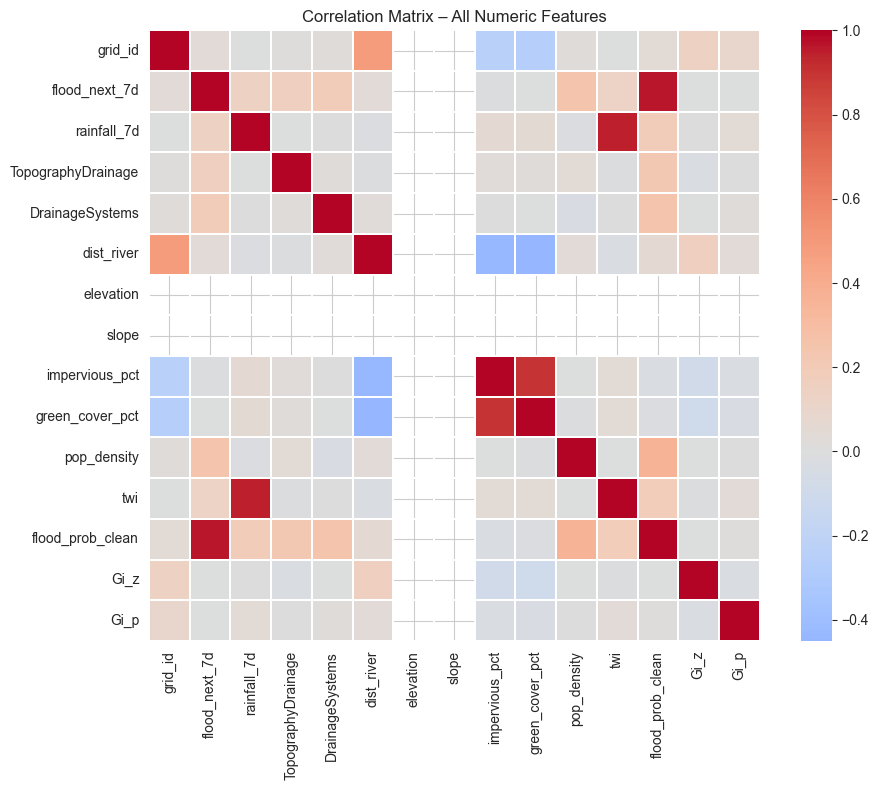

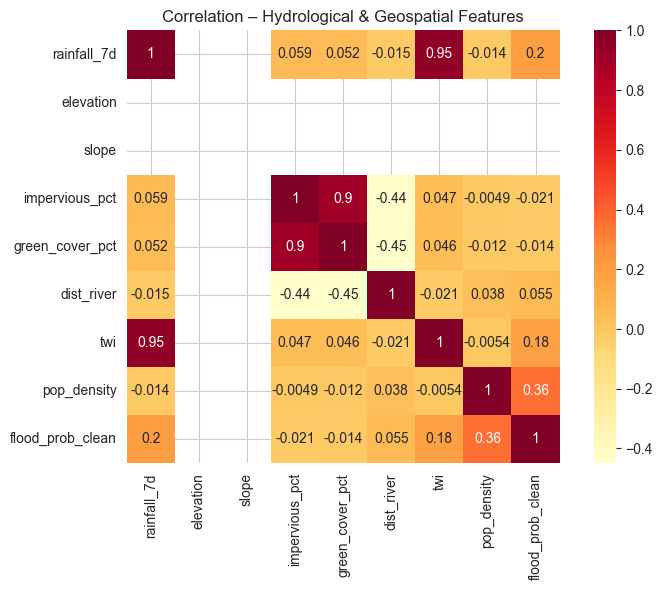

Saved correlation plots → maps/eda_corr.png, maps/eda_geo_feature_corr.png


In [43]:
# STEP 6.1 — CORRELATION HEATMAPS

import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# Load the most recent enhanced dataset
gdf = gpd.read_parquet("data/mumbai_grid_enhanced_v3.parquet")
print(f"Loaded {len(gdf)} cells for correlation analysis")

# Select numeric columns only
num_cols = gdf.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation matrix
corr = gdf[num_cols].corr(method='pearson')

# 1️⃣ Basic Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, linewidths=0.3)
plt.title("Correlation Matrix – All Numeric Features")
plt.tight_layout()
plt.savefig("maps/eda_corr.png", dpi=200)
plt.show()

# 2️⃣ Focused Geo-Feature Correlation
geo_feats = [
    'rainfall_7d', 'elevation', 'slope', 'impervious_pct',
    'green_cover_pct', 'dist_river', 'twi', 'pop_density', 'flood_prob_clean'
]
geo_corr = gdf[geo_feats].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(geo_corr, annot=True, cmap="YlOrRd", square=True)
plt.title("Correlation – Hydrological & Geospatial Features")
plt.tight_layout()
plt.savefig("maps/eda_geo_feature_corr.png", dpi=200)
plt.show()

print("Saved correlation plots → maps/eda_corr.png, maps/eda_geo_feature_corr.png")


In [44]:
# STEP 6.2 — FLOOD HOTSPOTS ON SATELLITE BASEMAP (with lat/lon tooltip)

import geopandas as gpd
import folium
from folium import plugins
from branca.colormap import linear

# Load data with Gi* and flood probability
gdf = gpd.read_parquet("data/mumbai_grid_enhanced_v3.parquet")

# Filter significant hotspots
hotspots = gdf[(gdf['Gi_z'] > 0) & (gdf['Gi_p'] < 0.1)].copy()
print(f"Displaying {len(hotspots)} significant flood-prone hotspots (Gi_z>0, Gi_p<0.1)")

# Compute centroids
hotspots['lat'] = hotspots.geometry.centroid.y
hotspots['lon'] = hotspots.geometry.centroid.x

# Initialize satellite basemap centered on Mumbai
m = folium.Map(location=[19.0760, 72.8777], zoom_start=11, tiles="Esri.WorldImagery")

# Color scale for Gi*
colormap = linear.Reds_09.scale(hotspots['Gi_z'].min(), hotspots['Gi_z'].max())
colormap.caption = "Local Gi* (z-score)"
colormap.add_to(m)

# Add hotspot points with both tooltip and popup
for _, row in hotspots.iterrows():
    tooltip_text = (
        f"Grid {row['grid_id']}<br>"
        f"Lat: {row['lat']:.5f}<br>"
        f"Lon: {row['lon']:.5f}"
    )
    popup_text = (
        f"<b>Grid ID:</b> {row['grid_id']}<br>"
        f"<b>Flood Prob:</b> {row['flood_prob_clean']:.3f}<br>"
        f"<b>Gi_z:</b> {row['Gi_z']:.2f}<br>"
        f"<b>Gi_p:</b> {row['Gi_p']:.3f}<br>"
        f"<b>Lat:</b> {row['lat']:.5f}<br>"
        f"<b>Lon:</b> {row['lon']:.5f}"
    )

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=6,
        color=colormap(row['Gi_z']),
        fill=True,
        fill_opacity=0.8,
        tooltip=tooltip_text,              # hover info
        popup=folium.Popup(popup_text, max_width=220)
    ).add_to(m)

folium.LayerControl().add_to(m)
m.save("maps/eda_hotspots_satellite_latlon.html")

print("Satellite hotspot map (with lat/lon tooltip) saved → maps/eda_hotspots_satellite_latlon.html")
m


Displaying 153 significant flood-prone hotspots (Gi_z>0, Gi_p<0.1)
Satellite hotspot map (with lat/lon tooltip) saved → maps/eda_hotspots_satellite_latlon.html


In [170]:
# STEP 6.3 — VERIFICATION SUMMARY

import geopandas as gpd

gdf = gpd.read_parquet("data/mumbai_grid_enhanced_v3.parquet")

print("🔍 Verification Summary")
print("-" * 50)
print(f"Total grid cells: {len(gdf)}")
print(f"Has flood_prob_clean: {'flood_prob_clean' in gdf.columns}")
print(f"Has Gi_z: {'Gi_z' in gdf.columns}")
print(f"Has Gi_p: {'Gi_p' in gdf.columns}")
print("\nFlood Probability Summary:")
print(gdf['flood_prob_clean'].describe())
print("\nGi_z Range:", gdf['Gi_z'].min(), "→", gdf['Gi_z'].max())
print("\n All outputs verified. Correlation and hotspot maps ready.")


🔍 Verification Summary
--------------------------------------------------
Total grid cells: 1530
Has flood_prob_clean: True
Has Gi_z: True
Has Gi_p: True

Flood Probability Summary:
count    1530.000000
mean        0.452828
std         0.334594
min         0.020000
25%         0.140000
50%         0.273333
75%         0.800000
max         0.986667
Name: flood_prob_clean, dtype: float64

Gi_z Range: -1.0292742280493477 → 1.0136236653540416

 All outputs verified. Correlation and hotspot maps ready.
